# Mapper Improvements for Py-Spinnaker2


In [ ]:
!pip install seaborn

In [1]:
from spinnaker2 import snn, hardware, mapper
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from io import StringIO

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
neuron_params = {
    "threshold": 1.0,
    "alpha_decay": 0.9,
    "i_offset": 0.0,
    "reset": "reset_by_subtraction",
}

In [4]:
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio  # free up some memory
        sys.stdout = self._stdout

## Even Distribution of weights 


#### Find max number of weights possible for 150 neurons

p = 0.72

In [ ]:
timesteps = 50
n_single = 155
dims = [100, n_single]
p_spike = 3 / timesteps
input_spikes = {
    n: np.where(np.random.choice([0, 1], size=timesteps, p=[1 - p_spike, p_spike]))[0].tolist()
    for n in range(dims[0])  # 10% chance of a spike
}

stim = snn.Population(size=dims[0], neuron_model="spike_list", params=input_spikes, name="stim")
pop1 = snn.Population(
    size=dims[1], neuron_model="lif", params=neuron_params, name="pop1", record=["spikes", "v"]
)

# pop2 = snn.Population(size=dims[2], neuron_model="lif", params=neuron_params, name="pop2", record=["spikes", "v"])
p_default = 0.99
fit = True
while fit:
    with Capturing() as output:

        mask = np.random.uniform(0, 1, size=(dims[0], dims[1])) > p_default
        weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * mask
        mask = weights != 0

        conns = []
        for x, y in zip(*weights.nonzero()):
            conns.append([x, y, weights[x, y], 1])
        proj = snn.Projection(pre=stim, post=pop1, connections=conns)
        net = snn.Network("my network")
        net.add(stim, pop1, proj)

        hw = hardware.SpiNNaker2Chip(eth_ip="192.168.1.53")
        try:
            hw.run(net, timesteps, fix_mem_overload=False, mapping_only=True)
            p_default *= 0.95
        except MemoryError as e:
            fit = False

        print(f"Probability of {p_default} leads to {'no'*(1 - fit)} fit")

p_default /= 0.95
print(f"final p = {p_default}")
mask = np.random.uniform(0, 1, size=(dims[0], dims[1])) > p_default
weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * mask
mask = weights != 0

conns = []
for x, y in zip(*weights.nonzero()):
    conns.append([x, y, weights[x, y], 1])
proj = snn.Projection(pre=stim, post=pop1, connections=conns)
net = snn.Network("my network")
net.add(stim, pop1, proj)

hw = hardware.SpiNNaker2Chip(eth_ip="192.168.1.53")
hw.run(net, timesteps, fix_mem_overload=False, mapping_only=True)

### Create net

In [5]:
try:
    n_single, p_default
except NameError:
    n_single = 154
    p_default = 0.72

timesteps = 50
dims = [100, 3 * n_single]
p_spike = 3 / timesteps
input_spikes = {
    n: np.where(np.random.choice([0, 1], size=timesteps, p=[1 - p_spike, p_spike]))[0].tolist()
    for n in range(dims[0])  # 10% chance of a spike
}

stim = snn.Population(size=dims[0], neuron_model="spike_list", params=input_spikes, name="stim")

In [6]:
pop1 = snn.Population(
    size=dims[1], neuron_model="lif", params=neuron_params, name="pop1", record=["spikes", "v"]
)
# pop2 = snn.Population(size=dims[2], neuron_model="lif", params=neuron_params, name="pop2", record=["spikes", "v"])

In [7]:
mask = np.random.uniform(0, 1, size=(dims[0], dims[1])) > p_default
weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * mask
mask = weights != 0

conns = []
for x, y in zip(*weights.nonzero()):
    conns.append([x, y, weights[x, y], 1])
proj = snn.Projection(pre=stim, post=pop1, connections=conns)
net = snn.Network("my network")
net.add(stim, pop1, proj)

#### Mapping fails before

In [8]:
try:
    hw = hardware.SpiNNaker2Chip(eth_ip="192.168.1.53")
    hw.run(net, timesteps, fix_mem_overload=False, mapping_only=True)
except MemoryError as e:
    print(e)
    print("Memory Overload !! ")

Used 3 out of 152 cores
Sim duration: 0.05 s
Actual duration (incl. offset): 0.060000000000000005
('syn_rows too large in population', 'pop1', ':', '0x20ec8', '0x1b000')
Memory Overload !! 


#### Allow mem_overload fix and show new mapping

In [9]:
hw = hardware.SpiNNaker2Chip(eth_ip="192.168.3.24")
hw.run(net, timesteps, iterative_mapping=True, mapping_only=True)

0it [00:00, ?it/s]

Mapping successful 
Final mapping: {<spinnaker2.snn.Population object at 0x7fea6eb82ea0>: {PE(1, 1, 0): 100}, <spinnaker2.snn.Population object at 0x7feab2eef2f0>: {PE(1, 1, 1): 154, PE(1, 1, 2): 154, PE(1, 1, 3): 154}}
Used 4 out of 152 cores
Run mapping only. No experiment is executed on the hardware.


In [10]:
even_slices = [
    hw.my_mapper.mapping.get_population_slice(pe) for pe in hw.my_mapper.pop_slices[pop1].keys()
]
# show distribution of weights for post-synaptic neurons
neurons, n_synapses = np.unique(weights.nonzero()[1], return_counts=True)
even_slice_sizes = [s.stop - s.start for s in even_slices]
even_num_syns = np.array([n_synapses[s.start : s.stop].sum() for s in even_slices])

## Uneven distribution

#### Create an unenven weight distribution:

In [11]:
n_weights = mask.sum()
offset = (n_weights.sum()) * (np.log(n_weights.sum())) / dims[0] - dims[1]
tau = -(dims[1] + offset) / np.log(mask.sum() + 1)
n_unenven_weights = -1 / tau * np.exp(-(np.arange(0, dims[1]) + offset) / tau)

plt.plot(n_unenven_weights / dims[0])
plt.xlabel("Neuron ID")
plt.ylabel("Number of Synapses")
plt.title(
    f"Probability of Synapses per Neuron \n Total = {n_unenven_weights.sum():.0f} (vs old {n_weights.sum()})"
)
plt.grid(visible=True)

In [12]:
unenven_mask = np.stack(
    [np.random.choice([0, 1], size=dims[0], p=[1 - p, p]) for p in n_unenven_weights / dims[0]], 1
)
unenven_weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * unenven_mask
conns = []
for x, y in zip(*unenven_weights.nonzero()):
    conns.append([x, y, unenven_weights[x, y], 1])
proj = snn.Projection(pre=stim, post=pop1, connections=conns)
net = snn.Network("my network")
net.add(stim, pop1, proj)

### Mapping obviously still fails without the fix

In [13]:
try:
    hw = hardware.SpiNNaker2Chip(eth_ip="192.168.1.53")
    hw.run(net, timesteps, fix_mem_overload=False, mapping_only=True)
except MemoryError as e:
    print(e)
    print("Memory Overload !! ")

Used 3 out of 152 cores
Sim duration: 0.05 s
Actual duration (incl. offset): 0.060000000000000005
('syn_rows too large in population', 'pop1', ':', '0x1e898', '0x1b000')
Memory Overload !! 


#### New mapping

In [14]:
hw = hardware.SpiNNaker2Chip(eth_ip="192.168.3.24")
hw.run(net, timesteps, iterative_mapping=True, mapping_only=True)

0it [00:00, ?it/s]

Mapping successful 
Final mapping: {<spinnaker2.snn.Population object at 0x7fea6eb82ea0>: {PE(1, 1, 0): 100}, <spinnaker2.snn.Population object at 0x7feab2eef2f0>: {PE(1, 1, 1): 186, PE(1, 1, 2): 160, PE(1, 1, 3): 116}}
Used 4 out of 152 cores
Run mapping only. No experiment is executed on the hardware.


#### Now pop slices are way different in size depending on what portion of neurons they include

In [15]:
uneven_slices = [
    hw.my_mapper.mapping.get_population_slice(pe) for pe in hw.my_mapper.pop_fits[pop1].keys()
]
# show distribution of weights for post-synaptic neurons
neurons, n_synapses = np.unique(unenven_weights.nonzero()[1], return_counts=True)
uneven_num_syns = np.array([n_synapses[s.start : s.stop].sum() for s in uneven_slices])
uneven_slice_sizes = [s.stop - s.start for s in uneven_slices]

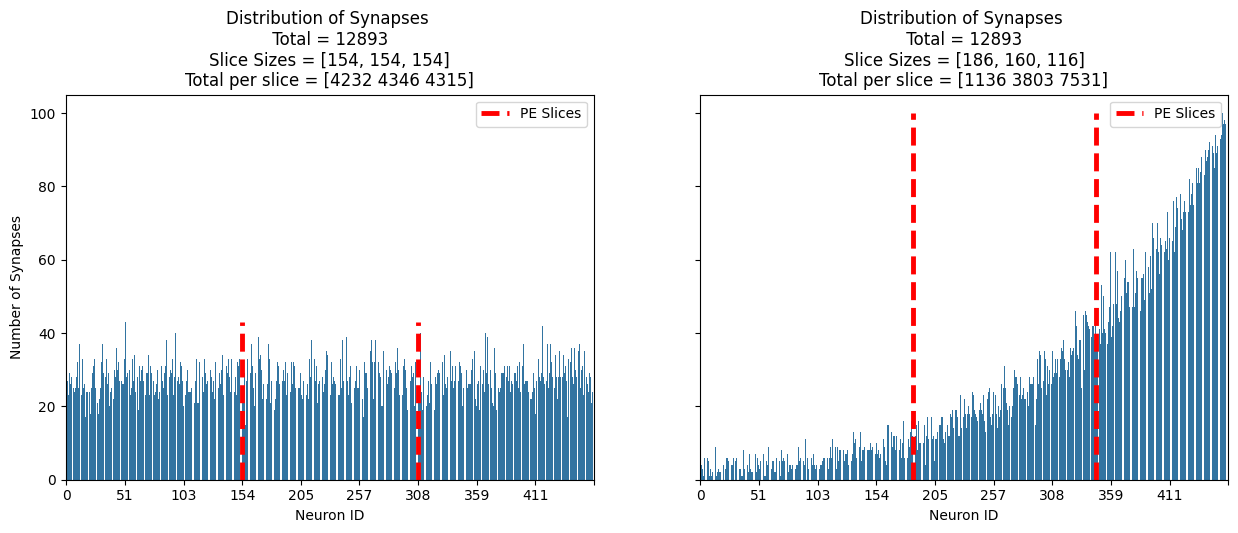

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for ax, slices, slice_sizes, n_syn_per_slice, w in zip(
    axs,
    [even_slices, uneven_slices],
    [even_slice_sizes, uneven_slice_sizes],
    [even_num_syns, uneven_num_syns],
    [weights, unenven_weights],
):

    neurons, n_synapses = np.unique(w.nonzero()[1], return_counts=True)
    ax.vlines(
        [s.stop for s in slices[:-1]],
        0,
        n_synapses.max(),
        color="r",
        linestyles="dashed",
        label="PE Slices",
        linewidth=3.5,
    )

    sns.barplot(x=neurons, y=n_synapses, ax=ax)
    ax.set_xlabel("Neuron ID")
    ax.set_ylabel("Number of Synapses")
    ax.set_xticks(np.linspace(0, dims[1], 10))

    ax.set_title(
        f"Distribution of Synapses \n Total = {weights.nonzero()[0].size} \n"
        + f"Slice Sizes = {slice_sizes}\n"
        + f"Total per slice = {n_syn_per_slice}"
    )

plt.show()

## Worst Case Scenario

We try here the worst case scenario where the uniform distribution completely fills the chip. It seems the mapper adapts well

In [27]:
timesteps = 50
dims = [100, 150 * n_single]
p_spike = 3 / timesteps
input_spikes = {
    n: np.where(np.random.choice([0, 1], size=timesteps, p=[1 - p_spike, p_spike]))[0].tolist()
    for n in range(dims[0])  # 10% chance of a spike
}

stim = snn.Population(size=dims[0], neuron_model="spike_list", params=input_spikes, name="stim")

In [28]:
pop1 = snn.Population(
    size=dims[1], neuron_model="lif", params=neuron_params, name="pop1", record=["spikes", "v"]
)
# pop2 = snn.Population(size=dims[2], neuron_model="lif", params=neuron_params, name="pop2", record=["spikes", "v"])

In [29]:
mask = np.random.uniform(0, 1, size=(dims[0], dims[1])) > (p_default * 1.018)
weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * mask
print(weights.nonzero()[0].size)
conns = []
for x, y in zip(*weights.nonzero()):
    conns.append([x, y, weights[x, y], 1])
proj = snn.Projection(pre=stim, post=pop1, connections=conns)
net = snn.Network("my network")
net.add(stim, pop1, proj)

616624


#### Mapping works for even dist but **fills** the chip

In [30]:
hw = hardware.SpiNNaker2Chip(eth_ip="192.168.3.24")
hw.run(net, timesteps, iterative_mapping=True, mapping_only=True)

0it [00:00, ?it/s]

Mapping successful 
Final mapping: {<spinnaker2.snn.Population object at 0x7fea684dd310>: {PE(1, 1, 0): 100}, <spinnaker2.snn.Population object at 0x7fea5d36b050>: {PE(1, 1, 1): 156, PE(1, 1, 2): 154, PE(1, 1, 3): 156, PE(1, 2, 0): 154, PE(1, 2, 1): 156, PE(1, 2, 2): 154, PE(1, 2, 3): 156, PE(1, 3, 0): 156, PE(1, 3, 1): 156, PE(1, 3, 2): 156, PE(1, 3, 3): 156, PE(1, 4, 0): 156, PE(1, 4, 1): 154, PE(1, 4, 2): 152, PE(1, 4, 3): 156, PE(1, 5, 0): 154, PE(1, 5, 1): 156, PE(1, 5, 2): 156, PE(1, 5, 3): 156, PE(1, 6, 0): 156, PE(1, 6, 1): 156, PE(1, 6, 2): 154, PE(1, 6, 3): 156, PE(2, 1, 0): 154, PE(2, 1, 1): 156, PE(2, 1, 2): 154, PE(2, 1, 3): 156, PE(2, 2, 0): 154, PE(2, 2, 1): 154, PE(2, 2, 2): 156, PE(2, 2, 3): 156, PE(2, 3, 0): 156, PE(2, 3, 1): 150, PE(2, 3, 2): 156, PE(2, 3, 3): 156, PE(2, 4, 0): 154, PE(2, 4, 1): 156, PE(2, 4, 2): 156, PE(2, 4, 3): 156, PE(2, 5, 0): 154, PE(2, 5, 1): 154, PE(2, 5, 2): 152, PE(2, 5, 3): 156, PE(2, 6, 0): 156, PE(2, 6, 1): 156, PE(2, 6, 2): 154, PE(2, 6

In [31]:
even_slices = [
    hw.my_mapper.mapping.get_population_slice(pe) for pe in hw.my_mapper.pop_fits[pop1].keys()
]

In [32]:
hw.used_cores

[PE(1, 1, 0),
 PE(1, 1, 1),
 PE(1, 1, 2),
 PE(1, 1, 3),
 PE(1, 2, 0),
 PE(1, 2, 1),
 PE(1, 2, 2),
 PE(1, 2, 3),
 PE(1, 3, 0),
 PE(1, 3, 1),
 PE(1, 3, 2),
 PE(1, 3, 3),
 PE(1, 4, 0),
 PE(1, 4, 1),
 PE(1, 4, 2),
 PE(1, 4, 3),
 PE(1, 5, 0),
 PE(1, 5, 1),
 PE(1, 5, 2),
 PE(1, 5, 3),
 PE(1, 6, 0),
 PE(1, 6, 1),
 PE(1, 6, 2),
 PE(1, 6, 3),
 PE(2, 1, 0),
 PE(2, 1, 1),
 PE(2, 1, 2),
 PE(2, 1, 3),
 PE(2, 2, 0),
 PE(2, 2, 1),
 PE(2, 2, 2),
 PE(2, 2, 3),
 PE(2, 3, 0),
 PE(2, 3, 1),
 PE(2, 3, 2),
 PE(2, 3, 3),
 PE(2, 4, 0),
 PE(2, 4, 1),
 PE(2, 4, 2),
 PE(2, 4, 3),
 PE(2, 5, 0),
 PE(2, 5, 1),
 PE(2, 5, 2),
 PE(2, 5, 3),
 PE(2, 6, 0),
 PE(2, 6, 1),
 PE(2, 6, 2),
 PE(2, 6, 3),
 PE(3, 1, 0),
 PE(3, 1, 1),
 PE(3, 1, 2),
 PE(3, 1, 3),
 PE(3, 2, 0),
 PE(3, 2, 1),
 PE(3, 2, 2),
 PE(3, 2, 3),
 PE(3, 3, 0),
 PE(3, 3, 1),
 PE(3, 3, 2),
 PE(3, 3, 3),
 PE(3, 4, 0),
 PE(3, 4, 1),
 PE(3, 4, 2),
 PE(3, 4, 3),
 PE(3, 5, 0),
 PE(3, 5, 1),
 PE(3, 5, 2),
 PE(3, 5, 3),
 PE(3, 6, 0),
 PE(3, 6, 1),
 PE(3, 6, 2),
 PE(3,

### Mapping works also for a uneven monotonous distribution

In [27]:
n_weights = mask.sum()
offset = (n_weights.sum()) * (np.log(n_weights.sum())) / dims[0] - dims[1]
tau = -(dims[1] + offset) / np.log(mask.sum() + 1)
n_unenven_weights = -1 / tau * np.exp(-(np.arange(0, dims[1]) + offset) / tau)
unenven_mask = np.stack(
    [np.random.choice([0, 1], size=dims[0], p=[1 - p, p]) for p in n_unenven_weights / dims[0]], 1
)
unenven_weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * unenven_mask

print(unenven_weights.nonzero()[0].size)
p_add = (1 - unenven_weights.nonzero()[0].size / weights.nonzero()[0].size) * 0.42
unenven_mask = np.stack(
    [np.random.choice([0, 1], size=dims[0], p=[1 - p, p]) for p in n_unenven_weights / dims[0]], 1
) + np.random.choice([0, 1], size=(dims[0], dims[1]), p=[1 - p_add, p_add])
unenven_weights = np.random.randint(1, 4, size=(dims[0], dims[1])) * unenven_mask

print(unenven_weights.nonzero()[0].size)

592785


609954


In [28]:
conns = []
for x, y in zip(*unenven_weights.nonzero()):
    conns.append([x, y, unenven_weights[x, y], 1])
proj = snn.Projection(pre=stim, post=pop1, connections=conns)
net = snn.Network("my network")
net.add(stim, pop1, proj)

In [30]:
hw = hardware.SpiNNaker2Chip(eth_ip="192.168.3.24")
hw.run(net, timesteps, iterative_mapping=True, mapping_only=True)

0it [00:00, ?it/s]

Mapping successful 
Final mapping: {<spinnaker2.snn.Population object at 0x7798242e7ee0>: {PE(1, 1, 0): 100}, <spinnaker2.snn.Population object at 0x7798242c00a0>: {PE(1, 1, 1): 190, PE(1, 1, 2): 190, PE(1, 1, 3): 190, PE(1, 2, 0): 190, PE(1, 2, 1): 190, PE(1, 2, 2): 190, PE(1, 2, 3): 190, PE(1, 3, 0): 190, PE(1, 3, 1): 190, PE(1, 3, 2): 190, PE(1, 3, 3): 190, PE(1, 4, 0): 190, PE(1, 4, 1): 190, PE(1, 4, 2): 190, PE(1, 4, 3): 190, PE(1, 5, 0): 188, PE(1, 5, 1): 186, PE(1, 5, 2): 188, PE(1, 5, 3): 188, PE(1, 6, 0): 188, PE(1, 6, 1): 188, PE(1, 6, 2): 188, PE(1, 6, 3): 188, PE(2, 1, 0): 186, PE(2, 1, 1): 186, PE(2, 1, 2): 186, PE(2, 1, 3): 186, PE(2, 2, 0): 186, PE(2, 2, 1): 184, PE(2, 2, 2): 186, PE(2, 2, 3): 184, PE(2, 3, 0): 186, PE(2, 3, 1): 184, PE(2, 3, 2): 184, PE(2, 3, 3): 184, PE(2, 4, 0): 184, PE(2, 4, 1): 184, PE(2, 4, 2): 184, PE(2, 4, 3): 182, PE(2, 5, 0): 182, PE(2, 5, 1): 182, PE(2, 5, 2): 182, PE(2, 5, 3): 180, PE(2, 6, 0): 178, PE(2, 6, 1): 180, PE(2, 6, 2): 180, PE(2, 6

In [31]:
uneven_slices = [
    hw.my_mapper.mapping.get_population_slice(pe) for pe in hw.my_mapper.pop_fits[pop1].keys()
]

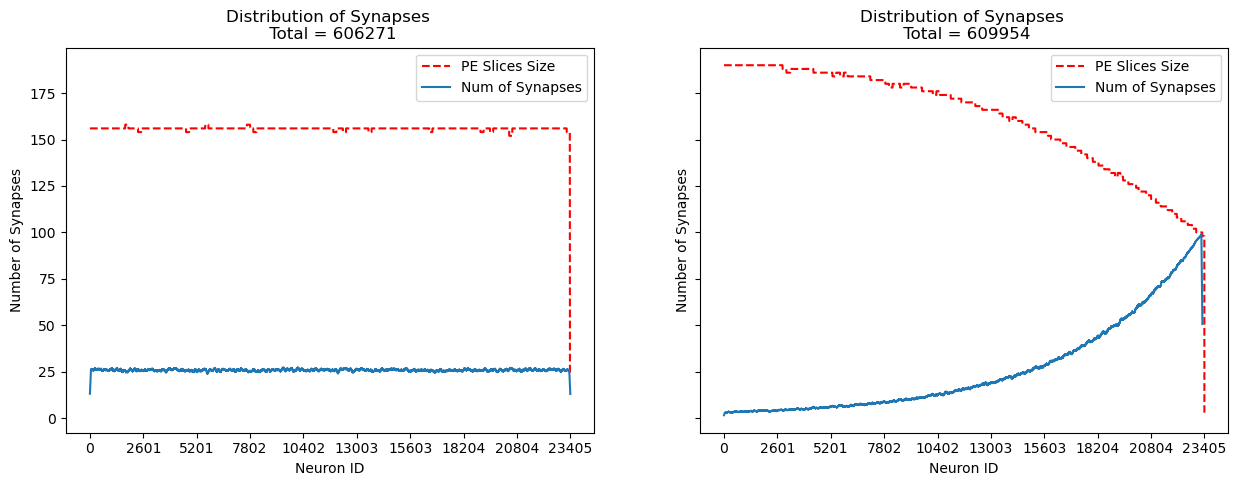

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for ax, slices, w in zip(axs, [even_slices, uneven_slices], [weights, unenven_weights]):

    size_per_neuron = [[s.size()] * s.size() for s in slices]
    size_per_neuron = np.concatenate(size_per_neuron)
    # show distribution of weights for post-synaptic neurons
    neurons, n_synapses = np.unique(w.nonzero()[1], return_counts=True)

    ax.plot(
        np.arange(dims[1]), size_per_neuron, color="r", linestyle="dashed", label="PE Slices Size"
    )

    ax.plot(np.convolve(n_synapses, np.ones(100) / 100, mode="same"), label="Num of Synapses")
    ax.set_xlabel("Neuron ID")
    ax.set_ylabel("Number of Synapses")
    ax.set_xticks(np.linspace(0, dims[1], 10))

    n_syn_per_slice = np.array([n_synapses[s.start : s.stop].sum() for s in slices])

    ax.legend()
    ax.set_title(f"Distribution of Synapses \n Total = {w.nonzero()[0].size}")

plt.show()

### TODO : Find a case with same number of weights where mapping fails. 

Probably something with peaks and lows